In [1]:
import sys
sys.path.append("/scratch/cl7201/region_decoding")
import scipy
import scipy.io
import pickle

from script.utils import *
from blind_localization.data.data_loading import *
from blind_localization.data.preprocess import *
from blind_localization.visualize import *

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_signal_labels(source_session, sample_rate=20000, T=30, data_type='LFP'):
    source_file = load_session_data("file_path_hpc.json", source_session)
    public_file = load_session_data("file_path_hpc.json", "public")
    signal_path = source_file["raw_lfp_path"] if data_type == 'LFP' else source_file["raw_signal_path"]
    print(signal_path)
    
    raw_signal, df, skipped_channels = load_data(signal_path, public_file["label_path"], source_file["xml_path"], sheet_name=source_file["sheet_name"],
                                                 sample_rate=sample_rate, T=T)
    channel_region_map, skipped_channels, channel_channel_map = process_labels(df, public_file["mapping_path"], skipped_channels)
    raw_signal = process_signals(raw_signal, channel_channel_map)

    channel_labels = np.load(f"/scratch/cl7201/region_decoding/data/Neuronexus/labels_{source_session}.npy")
    labels = np.argmax(channel_labels, axis=1) + 1
    channel_labels = channel_labels * labels[:, np.newaxis]
    class_labels = np.sum(channel_labels, axis=1).astype(int)
    
    dict = {0:5, 1:0, 2:1, 3:2, 4:3, 5:4}
    class_labels = np.array([dict[c] for c in class_labels])

    swr_file = scipy.io.loadmat(source_file["swr_path"])
    swr_timestamp = swr_file['ripples']['timestamps'][0][0]

    visualize_raw_signals(raw_signal, channel_region_map, skipped_channels, T=1000, sr=sample_rate)
  
    return raw_signal, class_labels, swr_timestamp

In [5]:
folder_path = "/scratch/th3129/region_decoding/data/Neuronexus"
session_config = {
    "visualize": True,
    'swr_flag': False,
    't_starts': np.arange(2160, 2340, 3),
    'sampling_rate': 1250,
    'trial_length': 3,
    'folder_path': folder_path
}
session_names = ["AD_HF01_1", "AD_HF02_2", "AD_HF02_4", "AD_HF03_1","AD_HF03_2", "NN_syn_01", "NN_syn_02"]

In [6]:
source_session = session_names[0]
sr = session_config['sampling_rate']
T = session_config['t_starts'][-1] - session_config['t_starts'][0] + (session_config['t_starts'][1] -  session_config['t_starts'][0])

/scratch/th3129/region_decoding/data/Neuronexus/AD_HF01_1_lfp.mat


100%|██████████| 1024/1024 [00:01<00:00, 953.72it/s]


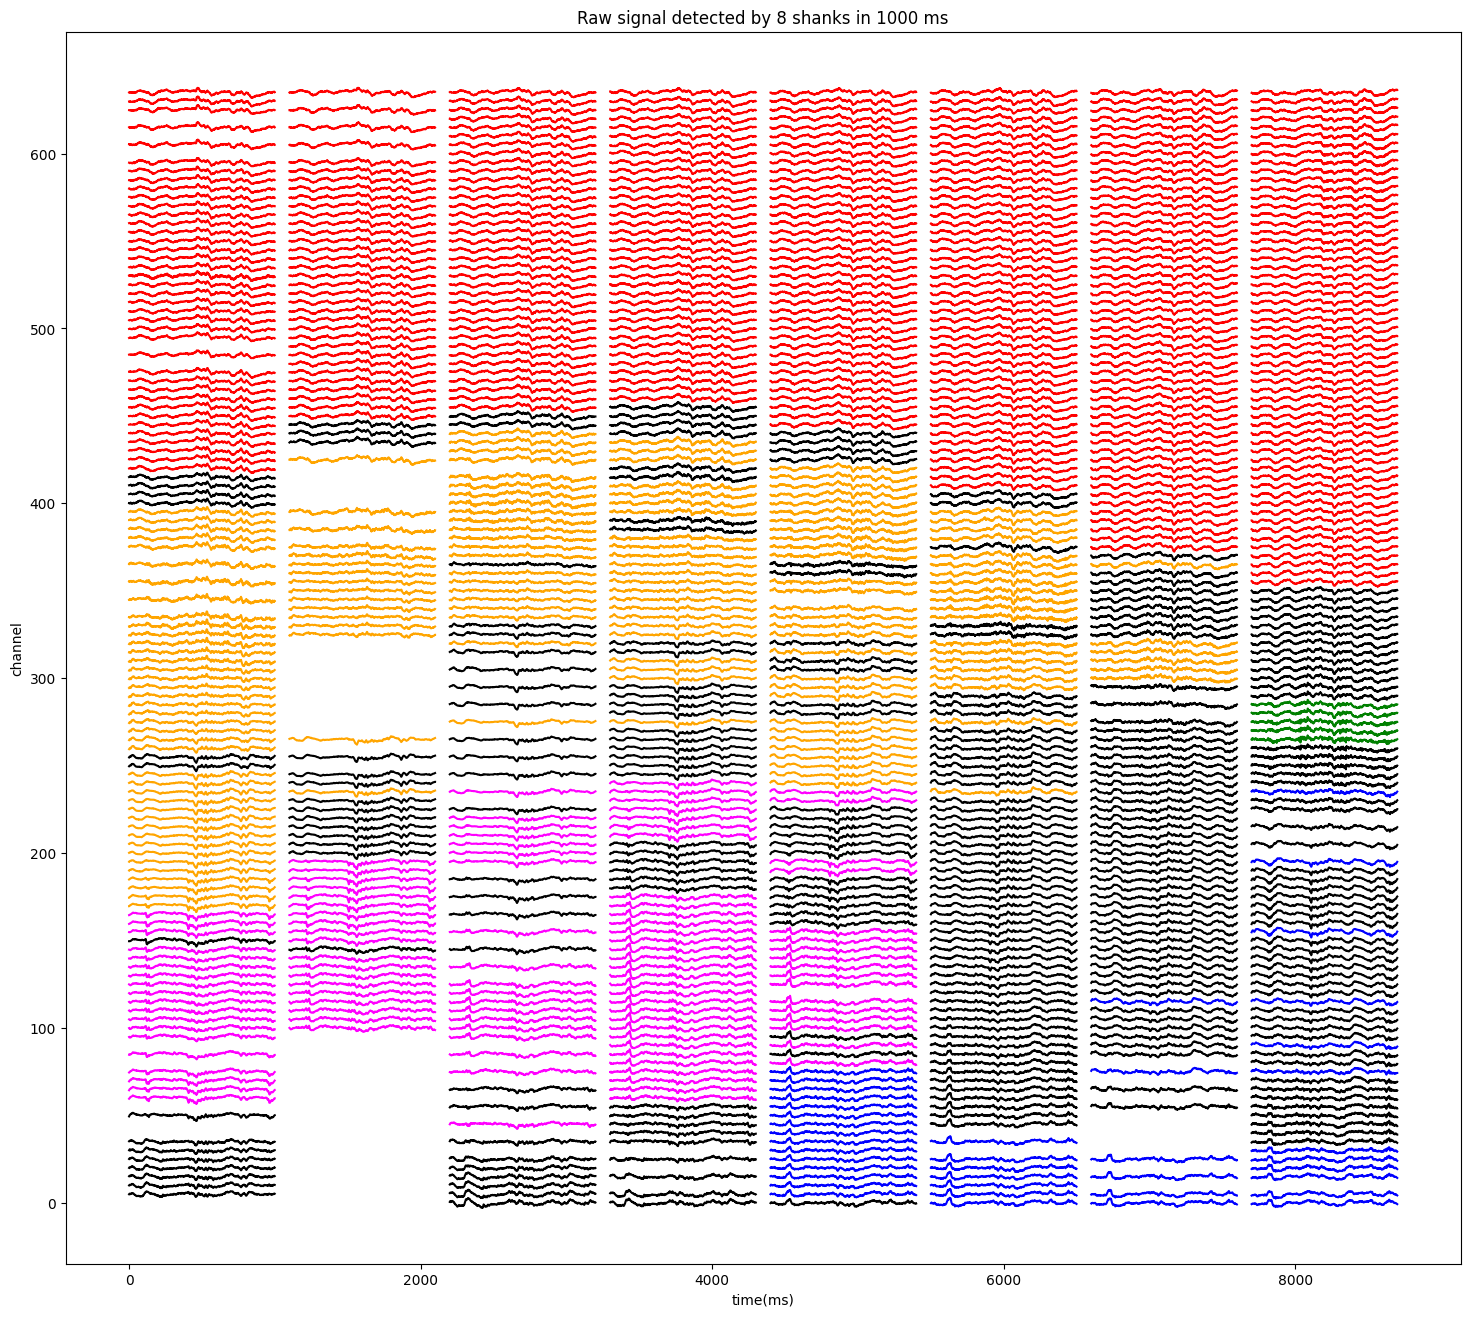

In [7]:
lfp_signal, channel_labels, swr_timestamp = load_signal_labels(source_session, sr, T, data_type='LFP')

/scratch/th3129/blind_localization/data/AD_HF01_1.mat


100%|██████████| 1024/1024 [00:22<00:00, 44.82it/s]


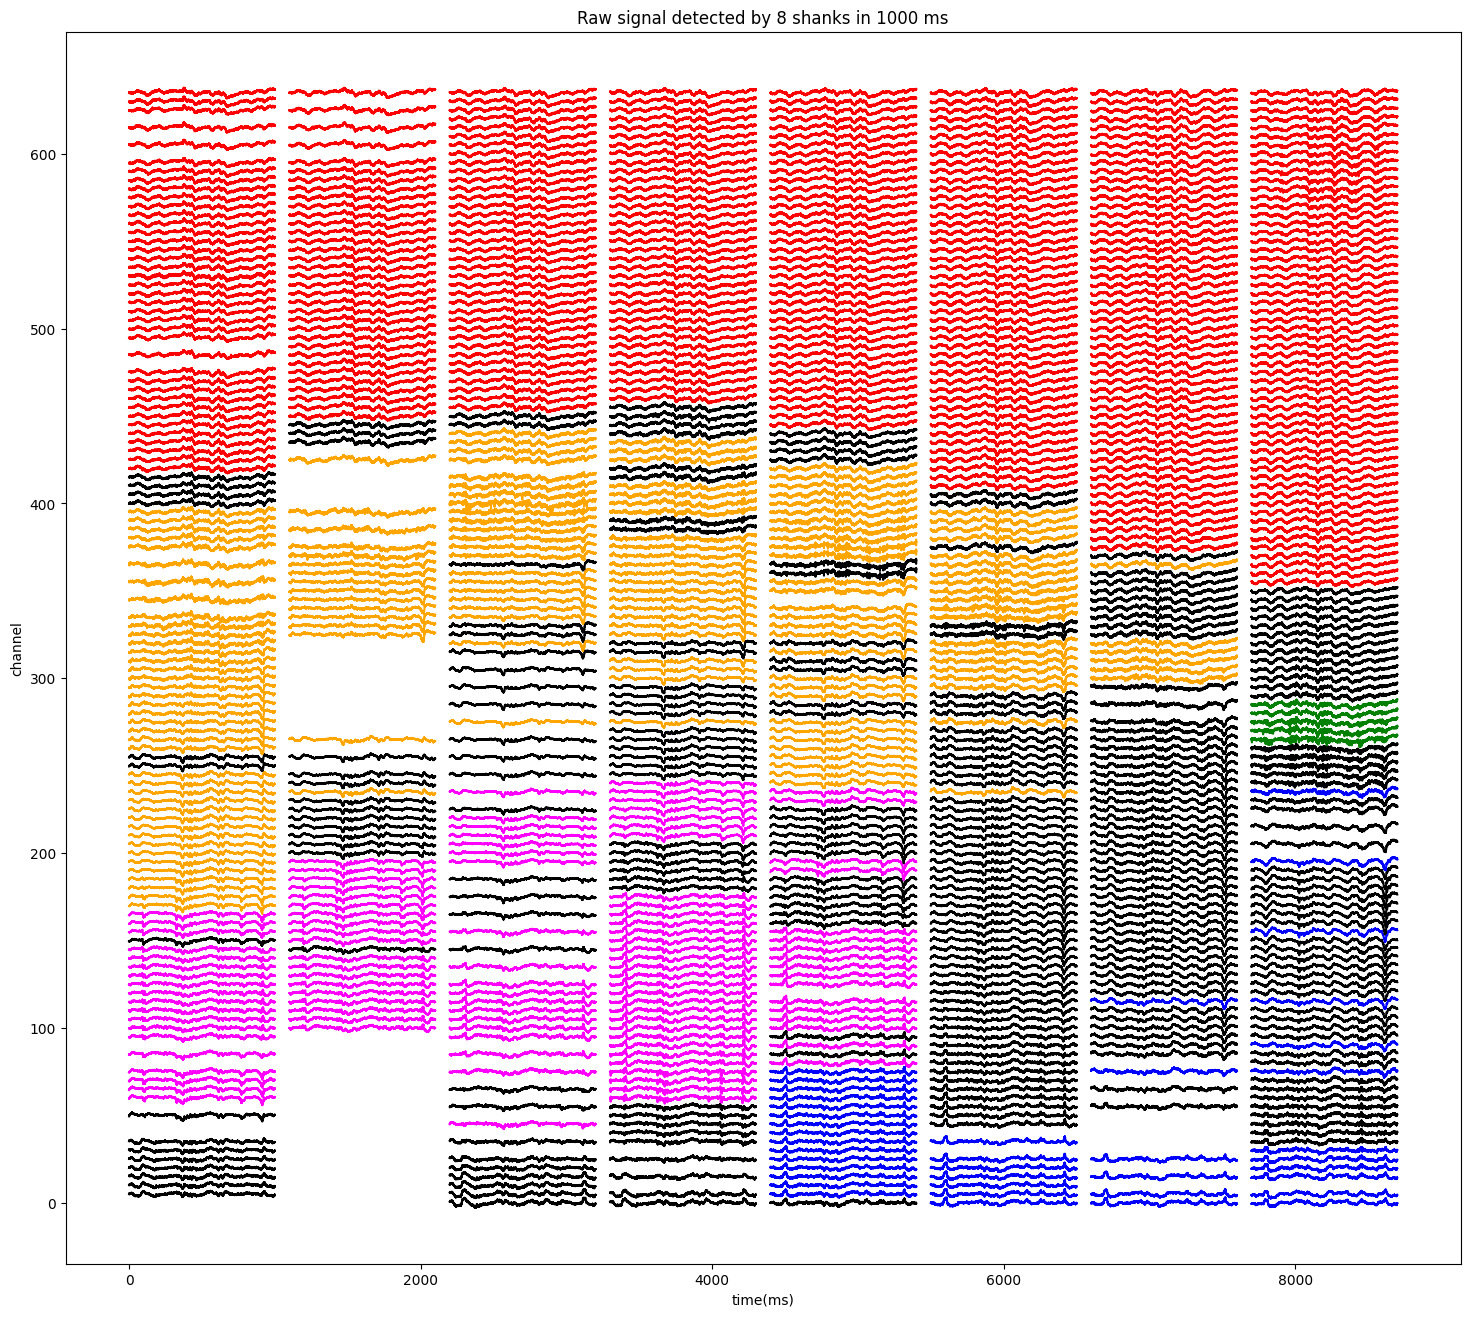

In [8]:
sr = 20000
raw_signal, channel_labels, swr_timestamp = load_signal_labels(source_session, sr, T, data_type='raw')

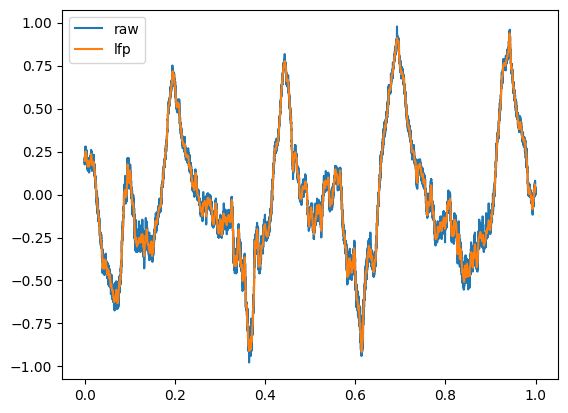

In [25]:
channel = 0
T=1
sr=20000
time = np.arange(0, T, 1/sr)
plt.plot(time, raw_signal[channel, :T*sr], label='raw')

sr=1250
time = np.arange(0, T, 1/sr)
plt.plot(time, lfp_signal[channel, :T*sr], label='lfp')
plt.legend()
plt.show()